In [15]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import defaultdict
import h5py
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import os
import regex as re

In [16]:
def plot_line_scan(file_path, fixed_gate, gate_tol=1e-6):
    """
    Plots a line scan for a given gate voltage from an HDF5 dataset.
    
    Parameters:
    - file_path: Path to the HDF5 file.
    - fixed_gate: The gate voltage to inspect.
    - gate_tol: Tolerance for selecting that gate.
    Returns:
    - yoko_sorted: Sorted Yoko values.
    - R_sorted: Sorted resistance values.
    """
    
    # Load data
    with h5py.File(file_path, "r") as f:
        yoko_vals = np.array(f["x0"])
        gate_vals = np.array(f["x1"])
        R_vals = np.array(f["y0"])  # Resistance

    # Check that data is not empty
    if yoko_vals.size == 0 or gate_vals.size == 0 or R_vals.size == 0:
        raise ValueError("One or more datasets in the HDF5 file are empty.")

    # Scale data
    fs = 14
    gain = 100
    I_exc = 1e-9

    yoko_vals = yoko_vals * 1000  # to nA
    R_vals = R_vals * (1 / (I_exc * gain))  # to ohms

    if yoko_vals.size == 0 or R_vals.size == 0:
        raise ValueError("No data found in the specified HDF5 file.")

    # Filter data
    print("The gate values are:", gate_vals)
    print("The fixed gate value is:", fixed_gate)
    mask = np.abs(gate_vals - fixed_gate) < gate_tol
    yoko_sel = yoko_vals[mask]
    R_sel = R_vals[mask]

    # Sort by Yoko values
    sort_idx = np.argsort(yoko_sel)
    yoko_sorted = yoko_sel[sort_idx]
    R_sorted = R_sel[sort_idx]

    print("Number of points selected:", mask.sum())
    if mask.sum() == 0:
        print("No data points match the gate voltage within tolerance.")

    #Plot
    plt.figure(figsize=(6, 4))
    plt.plot(yoko_sorted, R_sorted, lw=2)

    plt.xlabel('I$_{dc}$ (nA)', fontsize=fs)
    plt.ylabel("Resistance ($\\Omega$)", fontsize=fs)
    plt.xlim(0, 400)
    plt.ylim(0, 1000)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.title(f"Line scan at Gate {fixed_gate} V", fontsize=fs)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return yoko_sorted, R_vals

In [17]:
def get_critical_current(I, R):
    """
    Find the current where resistance transitions
    from flat (0) to nearly vertical.
    
    Parameters:
    - I: array-like, current values (nA)
    - R: array-like, resistance values (ohms)
    
    Returns:
    - critical_current: float, estimated critical current in nA
    """
    I = np.array(I)
    R = np.array(R)

    # Define a small threshold to account for noise
    threshold = 10

    # Find indices where resistance is below the threshold
    zero_resistance_indices = np.where(R <= threshold)[0]

    if len(zero_resistance_indices) > 0:
        # The last current where resistance is (effectively) zero
        critical_index = zero_resistance_indices[-1]
        critical_current = I[critical_index]
        print(f"Resistance at critical current index is {R[critical_index]}:")
        print(f"Critical current: {critical_current}")
        return critical_current
    else:
        print("No zero-resistance region found.")
        return None

In [18]:
# Take in gate voltage values and calculate critical current -> plot voltage vs critical current

def plot_V_vs_I_crit(file_path, gate_voltages, gate_tol=1e-6):
    """
    Plots critical current vs gate voltages for an HDF5 file.
    
    Parameters:
    - file_path: path to hdf5 file.
    - gate_voltages: List of gate voltages to inspect.
    - gate_tol: Tolerance for selecting that gate.
    """
    
    critical_currents = []

    for voltage in gate_voltages:
        I, R = plot_line_scan(file_path, fixed_gate=voltage, gate_tol=gate_tol)
        I_crit = abs(get_critical_current(I, R))
        critical_currents.append(I_crit)

    plt.figure(figsize=(8, 5))
    plt.scatter(gate_voltages, critical_currents, marker='o', linestyle='-', color='b')
    plt.xlabel('Gate Voltage (V)')
    plt.ylabel('Critical Current (nA)')
    plt.title('Critical Current vs Gate Voltage')
    plt.grid(True)
    plt.show()

    return critical_currents, gate_voltages

In [19]:
def plot_line_scan_repeats(file_path, fixed_gate, gate_tol=1e-6):
    """
    Plots a line scan for a given gate voltage from an HDF5 dataset with repeats.
    
    Parameters:
    - file_path: Path to the HDF5 file.
    - fixed_gate: The gate voltage to inspect.
    - gate_tol: Tolerance for selecting that gate.
    Returns:
    A dictionary mapping repeat number to sorted Yoko values, R values, voltage values
    """
    
    # Load data
    with h5py.File(file_path, "r") as f:
        yoko_vals = np.array(f["x0"]) # Current bias (µA)
        rep_idx = np.array(f["x1"])
        gate_vals = np.array(f["x2"])
        R_vals = np.array(f["y0"])  # Resistance
        V_vals = np.array(f['y3'])      # Voltage (raw)

    # Scale data
    #100x gain from pre amplifier for both AC and DC
    #1 nA of excitation current
    fs = 14
    gain = 100
    I_exc = 1e-9
        
    yoko_vals= yoko_vals * 1000 #Converting y to nA

    R_vals = R_vals * (1 / (I_exc*gain))
    
    V_vals = V_vals / (gain)

    # === FILTER: Only rows where Gate ~ fixed_gate ===
    mask = np.abs(gate_vals - fixed_gate) < gate_tol
    yoko_sel = yoko_vals[mask]
    rep_sel = rep_idx[mask]
    R_sel = R_vals[mask]
    V_sel = V_vals[mask]

    # Prepare dictionary to store results
    rep_dict = {}

    unique_reps = np.unique(rep_sel)
    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)


    # Store sorted values for each repeat in the dictionary
    for r in unique_reps:
        mask_r = rep_sel == r
        sort_idx = np.argsort(yoko_sel[mask_r])
        sorted_yoko = yoko_sel[mask_r][sort_idx]
        sorted_R = R_sel[mask_r][sort_idx]
        sorted_V = V_sel[mask_r][sort_idx]
        # ax1.plot(sorted_yoko, sorted_R, label=f"Rep {int(r)}")
        # ax2.plot(sorted_yoko, sorted_V, label=f"Rep {int(r)}")
        rep_dict[r] = (sorted_yoko, sorted_R, sorted_V)  # Store in hashmap

    # # R vs I plot
    # ax1.set_ylabel("Resistance ($\\Omega$)", fontsize=fs)
    # ax1.set_xlim(200, 1000)
    # ax1.set_ylim(0, 500)
    # ax1.legend()
    # ax1.set_title(f"Line scan at Gate {fixed_gate} V")
    # ax1.grid(False)

    # # V vs I plot
    # ax2.set_xlabel('I$_{dc}$ (nA)', fontsize=fs)
    # ax2.set_ylabel("Voltage (V)", fontsize=fs)
    # ax2.legend()
    # ax2.grid(False)

    # plt.tight_layout()
    # plt.show()

    return rep_dict

In [20]:
# Take in gate voltage values and calculate critical current -> plot voltage vs critical current for repeats
def plot_V_vs_I_crit_repeats(file_path, gate_voltages, gate_tol=1e-6):
    """
    Plots critical current vs gate voltages for an HDF5 file with repeats.
    Plots an average of all 5 repeats with error bars (max and min).
    Also plots the average critical current from the closest 3 repeats with the smallest spread.
    
    Parameters:
    - file_path: path to hdf5 file.
    - gate_voltages: List of gate voltages to inspect.
    - gate_tol: Tolerance for selecting that gate.
    """
    
    # Dictionary: repeat index -> list of I_crit for each gate voltage
    avg_critical_currents = []
    best_avg_critical_currents = []
    min_crit = []
    max_crit = []

    for voltage in gate_voltages:
        rep_dict = plot_line_scan_repeats(file_path, fixed_gate=voltage, gate_tol=gate_tol)
        avg = []

        # For each repeat, calculate critical current
        for r, (I, R, V) in rep_dict.items():
            avg.append(abs(get_critical_current(I, R)))

        min_crit.append(np.min(avg))
        max_crit.append(np.max(avg))

        print(min_crit)
        print(max_crit)

        # Find closest 3 repeats (exclude outliers)
        # Get all combinations of 3 currents
        combos = list(combinations(avg, 3))

        # Find the combo with the smallest spread (max - min)
        best_combo = min(combos, key=lambda x: np.max(x) - np.min(x))
        
        best_avg_critical_currents.append(np.mean(best_combo))

        avg_critical_currents.append(np.mean(avg))

    # lower_error = np.array(avg_critical_currents) - np.array(min_crit)
    # upper_error = np.array(max_crit) - np.array(avg_critical_currents)

    # plt.errorbar(gate_voltages, avg_critical_currents, yerr=[lower_error, upper_error], fmt='o')
    # plt.scatter(gate_voltages, best_avg_critical_currents, color='r', label='Best 3 Average Critical Current')

    # plt.xlabel('Gate Voltage (V)')
    # plt.ylabel('Critical Current (nA)')
    # plt.title('Average Critical Current vs Gate Voltage')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    return avg_critical_currents, best_avg_critical_currents, min_crit, max_crit

In [21]:
def get_normal_resistance(I, V, gate_voltage):
    """
    Find the slope of a voltage vs current graph AKA normal resistance.
    
    Parameters:
    - I: array-like, current values (nA)
    - V: array-like, voltage values (V)
    
    Returns:
    - normal_resistance: float, estimated normal resistance (slope of V vs I)
    - x_intercept: float, x-intercept of the linear fit (where V = 0)
    """
    I = np.array(I)
    V = np.array(V)

    # Ensure matching lengths
    min_length = min(len(I), len(V))
    I = I[:min_length]
    V = V[:min_length]

    # === ROI: Linear fit near x ≈ 8–10 ===
    roi_mask = (I >= 8) & (V <= 10)
    I_roi = I[roi_mask]
    V_roi = V[roi_mask]

    # Fit a line to the ROI
    coeffs = np.polyfit(I_roi, V_roi, 1)
    slope =  1e9 * coeffs[0]     # Units: 1e9 V/nA → Ω
    intercept = coeffs[1]

    # X-intercept (where V = 0)
    x_intercept = -intercept / slope

    #fig, ax = plt.subplots()
    # ax.plot(I, V, label='Gate Voltage {}'.format(gate_voltage))
    # ax.set_xlabel("Current (nA)")
    # ax.set_ylabel("Voltage (V)")
    # ax.set_title("IV Curve")
    # plt.legend()
    # plt.show()

    return slope, x_intercept

In [22]:
def get_dV_dI(I_point, I, V):
    """
    Find the derivative of a voltage vs current graph AKA dV/dI near a
    given point.
    
    Parameters:
    - I: array-like, current values (nA)
    - V: array-like, voltage values (V)
    
    Returns:
    - dV_dI: float, estimated derivative (slope of V vs I near I_point)
    """
    I = np.array(I)
    V = np.array(V)

    # Ensure matching lengths
    min_length = min(len(I), len(V))
    I = I[:min_length]
    V = V[:min_length]

     # Compute dV/dI using numpy.gradient
    dV_dI = np.gradient(V, I)  # dV/dI at each point[2][5]

    # Find index of I closest to I_point
    idx = np.abs(I - I_point).argmin()

    return dV_dI[idx]

In [23]:
def V_vs_Rn(file_path, gate_voltages, gate_tol=1e-6):
    """
    Calculates normal resistance (average of best 3) vs gate voltages for an HDF5 file.
    
    Parameters:
    - file_path: path to hdf5 file.
    - gate_voltages: List of gate voltages to inspect.
    - gate_tol: Tolerance for selecting that gate.
    """
    
    Rn = []
    (I, R, G)  = plot_line_scan(file_path, fixed_gate=voltage, gate_tol=gate_tol)

    for voltage in gate_voltages:
        # Calculate normal resistance
        Rn.append(abs(get_normal_resistance(I, V, voltage)[0]))
        
        return Rn

In [24]:
def V_vs_Rn_repeats(file_path, gate_voltages, gate_tol=1e-6):
    """
    Calculates normal resistance (average of best 3) vs gate voltages for an HDF5 file with repeats.
    Also plots the average normal resistance from the closest 3 repeats with the smallest spread.
    
    Parameters:
    - file_path: path to hdf5 file.
    - gate_voltages: List of gate voltages to inspect.
    - gate_tol: Tolerance for selecting that gate.
    """
    
    # Dictionary: repeat index -> list of I_crit for each gate voltage
    best_avg_normal_R = []
    min_R = []
    max_R = []

    for voltage in gate_voltages:
        rep_dict = plot_line_scan_repeats(file_path, fixed_gate=voltage, gate_tol=gate_tol)
        avg = []

        # For each repeat, calculate normal resistance
        for r, (I, R, V) in rep_dict.items():
            avg.append(abs(get_normal_resistance(I, V, voltage)[0]))

        min_R.append(np.min(avg))
        max_R.append(np.max(avg))

        print(min_R)
        print(max_R)

        # Find closest 3 repeats (exclude outliers)
        # Get all combinations of 3 currents
        combos = list(combinations(avg, 3))

        # Find the combo with the smallest spread (max - min)
        best_combo = min(combos, key=lambda x: np.max(x) - np.min(x))
        
        best_avg_normal_R.append(np.mean(best_combo))

    return best_avg_normal_R

In [25]:
def plot_V_vs_IcRn(jj_number, outer_folder, map_2d, gate_voltages, gate_tol=1e-6, repeats=True):
    """
    Plots normal resistance * critical current vs gate voltage for an HDF5 file.
    
    Parameters:
    - file_path: path to folder containing folders of hdf5 files.
    - map_2d: path to 2D map hdf5 file from which we get critical current
    - gate_voltages: List of gate voltages to inspect.
    - gate_tol: Tolerance for selecting that gate.
    """
    
    normal_resistances = []
    differential_resistances = []

    for V in gate_voltages:
        print(f"Processing gate voltage: {V} V")
        found = False
        # Format the voltage string as it appears in the folder name
        voltage_str = f"{V}V"
        for subfolder in os.listdir(outer_folder):
            # Check if subfolder ends with the voltage string
            if subfolder.endswith(voltage_str):
                subfolder_path = os.path.join(outer_folder, subfolder)
                hdf_path = os.path.join(subfolder_path, 'dataset.hdf5')
                if os.path.isfile(hdf_path):
                    with h5py.File(hdf_path, 'r') as f:
                        yoko_vals = np.array(f['x0'])  # Current bias (µA)
                        R_vals = np.array(f['y0'])  # Resistance
                        V_vals = np.array(f['y3'])  # Voltage (raw)

                        # Scale data
                        fs = 14
                        gain = 100
                        I_exc = 1e-9
                        yoko_vals = yoko_vals * 1000  # to nA
                        R_vals = R_vals * (1 / (I_exc * gain))  # to ohms
                        V_vals = V_vals / gain  # to volts

                        Rn = get_normal_resistance(yoko_vals, V_vals, V)[0] # Ω

                        print("The normal resistance is," + str(Rn) + "for " + subfolder)

                        normal_resistances.append(Rn)

                        # #Also plot dV/dI
                        # dV_dI = np.gradient(V_vals, yoko_vals*1e-9)  # get dV/dI for each I value

                        # plt.plot(yoko_vals, dV_dI, label=r'$dV/dI$')
                        # plt.xlabel('Current (nA)')
                        # plt.ylabel(r'$dV/dI$ (Ohms)')
                        # plt.title(f'Differential Resistance vs Current (Gate Voltage: {V:.2f} V)')
                        # plt.legend()
                        # plt.show()

                        # #Find differential resistance between 8000 nA and 10000 nA
                        # mask = (yoko_vals >= 8000) & (yoko_vals <= 10000)
                        # dV_dI_roi = dV_dI[mask]
                        # print(dV_dI_roi)

                        # #Ignore nan values
                        # differential_resistances.append(np.nanmean(dV_dI_roi))

                        
                    found = True
                    break
        if not found:
            normal_resistances.append(np.nan)

    fig, ax = plt.subplots()
    print(differential_resistances)
    ax.scatter(gate_voltages, normal_resistances, label='Line of Best Fit (Linear fit near x ≈ 8V–10V)')
    #ax.scatter(gate_voltages, differential_resistances, color='orange', label='Differential Resistance')
    ax.set_ylabel("Normal Resistance (Ω)")
    ax.set_xlabel('Gate Voltage (V)')
    ax.set_title("Normal Resistance vs. Gate Voltage")
    ax.legend()
    plt.show()

    if repeats:
        avg_Ic, best_avg_Ic, min_crit, max_crit = plot_V_vs_I_crit_repeats(map_2d, gate_voltages, gate_tol=1e-6)
        avg_R = V_vs_Rn_repeats(map_2d, gate_voltages, gate_tol=1e-6)

        lower_error = np.array(avg_Ic) - np.array(min_crit)
        upper_error = np.array(max_crit) - np.array(avg_Ic)

        plt.errorbar(gate_voltages, avg_Ic, yerr=[lower_error, upper_error], fmt='o')
        plt.scatter(gate_voltages, best_avg_Ic, color='r', label='Best 3 Average Critical Current')


    else:
        avg_Ic, _ = plot_V_vs_I_crit(map_2d, gate_voltages, gate_tol=1e-6)
        avg_R = V_vs_Rn(map_2d, gate_voltages, gate_tol=1e-6)


    plt.xlabel('Gate Voltage (V)')
    plt.ylabel('Critical Current (nA)')
    plt.title('Average Critical Current vs Gate Voltage')
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.scatter(gate_voltages, 1e-3 * np.array(normal_resistances)*np.array(best_avg_Ic), label='Ic * Rn (Individual)')
    plt.scatter(gate_voltages, 1e-3*np.array(avg_R)*np.array(avg_Ic), color = 'orange', label='Ic * Rn (2D Scan)')
    plt.legend()

    plt.xlabel('Gate Voltage (V)')
    plt.ylabel('Ic * Rn (µV)')
    plt.title(f'Ic * Rn vs Gate Voltage (JJ #{jj_number})')

In [26]:
JJ23_2D_Rep_Cold = r"/Users/ddoken/Downloads/LPS/2DMapsColdRep/20250606-164526-447-279533-YokoVsGate_Repeat_JJ_307_01_JJ23_1nA_5reps/dataset.hdf5"

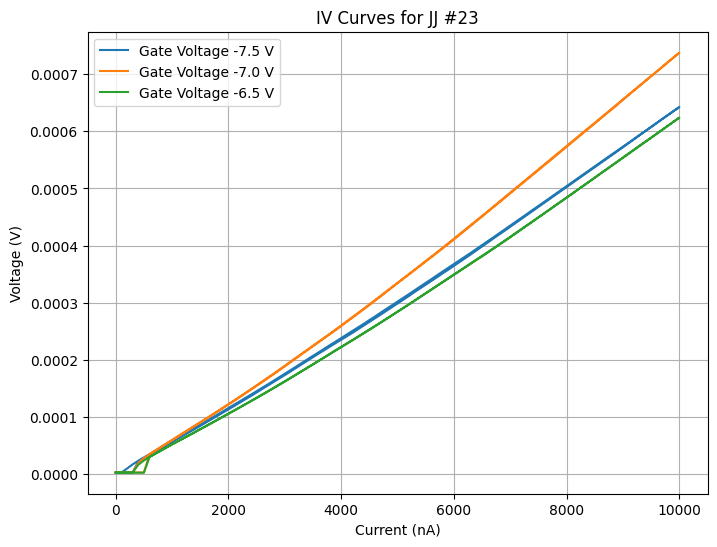

In [27]:
plt.figure(figsize=(8, 6))
for V in [-7.5,-7.0,-6.5]:
    voltage_str = f"{V}V"
    for subfolder in os.listdir(r'/Users/ddoken/Downloads/LPS/LongIc/JJ23_Normal_Resistance'):
        # Check if subfolder ends with the voltage string
        if subfolder.endswith(voltage_str):
            subfolder_path = os.path.join(r'/Users/ddoken/Downloads/LPS/LongIc/JJ23_Normal_Resistance', subfolder)
            hdf_path = os.path.join(subfolder_path, 'dataset.hdf5')
            if os.path.isfile(hdf_path):
                with h5py.File(hdf_path, 'r') as f:
                    yoko_vals = np.array(f['x0'])  # Current bias (µA)
                    R_vals = np.array(f['y0'])  # Resistance
                    V_vals = np.array(f['y3'])  # Voltage (raw)

                    # Scale data
                    fs = 14
                    gain = 100
                    I_exc = 1e-9
                    yoko_vals = yoko_vals * 1000  # to nA
                    R_vals = R_vals * (1 / (I_exc * gain))  # to ohms
                    V_vals = V_vals / gain  # to volts

    plt.plot(yoko_vals, V_vals, label=f'Gate Voltage {V} V')

plt.xlabel('Current (nA)')
plt.ylabel('Voltage (V)')
plt.title(f'IV Curves for JJ #23')
plt.legend()
plt.grid(True)
plt.show()

Processing gate voltage: -8.0 V
The normal resistance is,65.270012079058for 20250613-112020-774-812c55-RvsSource_JJ_307_01_JJ23_1nA_Vg=-8.0V
Processing gate voltage: -7.5 V
The normal resistance is,64.65699119162929for 20250613-113128-123-98efaf-RvsSource_JJ_307_01_JJ23_1nA_Vg=-7.5V
Processing gate voltage: -7.0 V
The normal resistance is,75.01269102394251for 20250613-141949-964-2efd04-RvsSource_JJ_307_01_JJ23_1nA_Vg=-7.0V
Processing gate voltage: -6.5 V
The normal resistance is,63.12204215859598for 20250613-144026-136-c2d06a-RvsSource_JJ_307_01_JJ23_1nA_Vg=-6.5V
Processing gate voltage: -6.0 V
The normal resistance is,62.25498065613572for 20250613-144558-872-344d6c-RvsSource_JJ_307_01_JJ23_1nA_Vg=-6.0V
Processing gate voltage: -5.5 V
The normal resistance is,62.9530536497151for 20250613-145105-360-3a78f4-RvsSource_JJ_307_01_JJ23_1nA_Vg=-5.5V
Processing gate voltage: -5.0 V
The normal resistance is,61.573678710591146for 20250613-145521-054-4003a5-RvsSource_JJ_307_01_JJ23_1nA_Vg=-5.0V
P

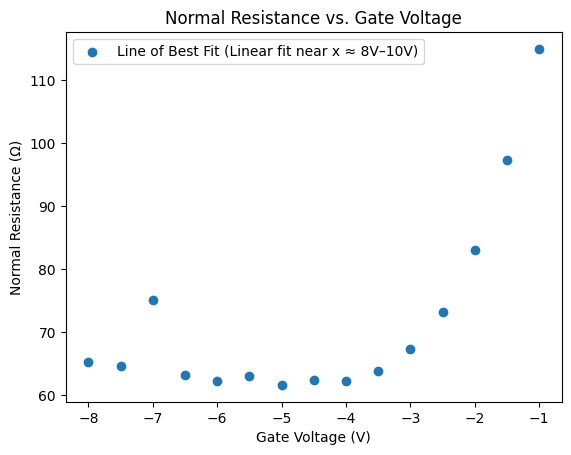

Resistance at critical current index is 1.1874612227:
Critical current: 265.0
Resistance at critical current index is 2.8198300583:
Critical current: 240.0
Resistance at critical current index is 5.214271254800001:
Critical current: 251.0
Resistance at critical current index is 1.4956138727000001:
Critical current: 249.0
Resistance at critical current index is 4.3379500879999995:
Critical current: 242.0
[np.float64(240.0)]
[np.float64(265.0)]
Resistance at critical current index is 1.1158023483:
Critical current: 298.0
Resistance at critical current index is 2.035927622:
Critical current: 261.0
Resistance at critical current index is 2.0520204203:
Critical current: 292.0
Resistance at critical current index is 9.3485198249:
Critical current: 327.0
Resistance at critical current index is 2.820236773:
Critical current: 285.00000000000006
[np.float64(240.0), np.float64(261.0)]
[np.float64(265.0), np.float64(327.0)]
Resistance at critical current index is 2.960187544:
Critical current: 283

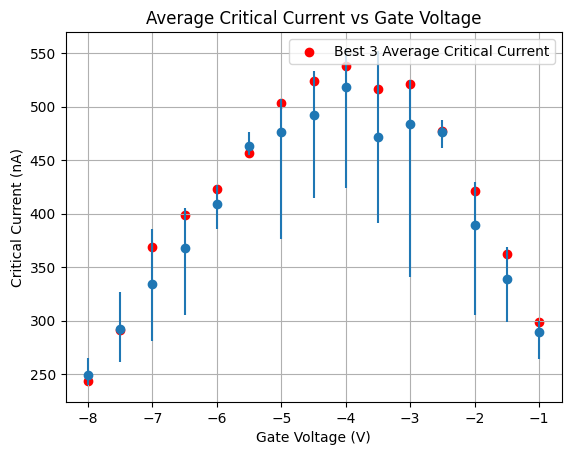

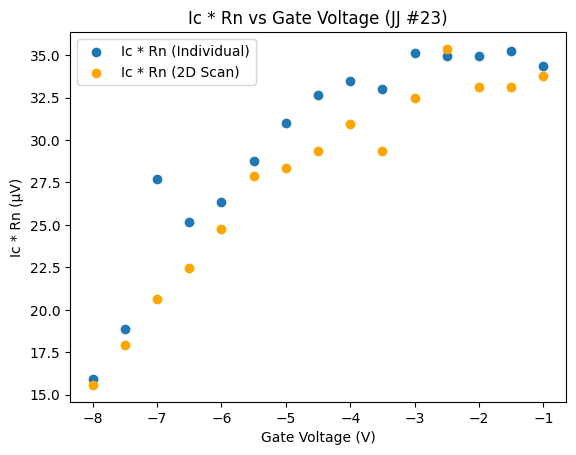

In [28]:
plot_V_vs_IcRn(23, r'/Users/ddoken/Downloads/LPS/LongIc/JJ23_Normal_Resistance', JJ23_2D_Rep_Cold, np.arange(-8, -0.5, 0.5))

Processing gate voltage: -8.0 V
The normal resistance is,89.85185015838599for 20250618-102956-306-e16a7b-RvsSource_JJ_307_01_JJ11_1nA_Vg=-8.0V
Processing gate voltage: -7.5 V
The normal resistance is,90.05415680690082for 20250618-104146-173-f02e89-RvsSource_JJ_307_01_JJ11_1nA_Vg=-7.5V
Processing gate voltage: -7.0 V
The normal resistance is,90.98663165229536for 20250618-104617-835-418415-RvsSource_JJ_307_01_JJ11_1nA_Vg=-7.0V
Processing gate voltage: -6.5 V
The normal resistance is,91.72574029120929for 20250618-105138-973-fd242f-RvsSource_JJ_307_01_JJ11_1nA_Vg=-6.5V
Processing gate voltage: -6.0 V
The normal resistance is,92.75700923621379for 20250618-105600-163-b6efd1-RvsSource_JJ_307_01_JJ11_1nA_Vg=-6.0V
Processing gate voltage: -5.5 V
The normal resistance is,94.6906813044106for 20250618-110114-478-922601-RvsSource_JJ_307_01_JJ11_1nA_Vg=-5.5V
Processing gate voltage: -5.0 V
The normal resistance is,96.23228963903405for 20250618-110614-037-657683-RvsSource_JJ_307_01_JJ11_1nA_Vg=-5.0V


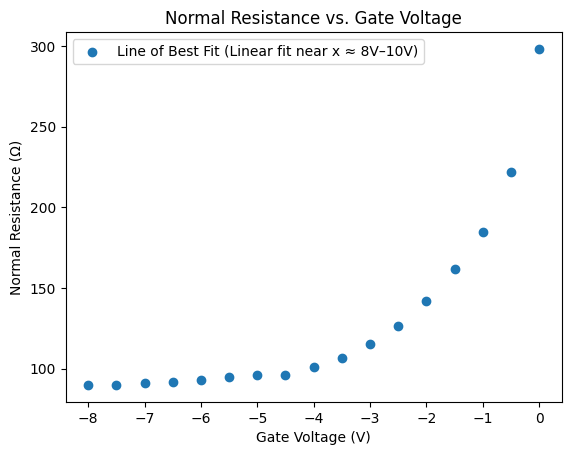

Resistance at critical current index is 3.5463037307:
Critical current: 238.00000000000003
Resistance at critical current index is 3.1560384173:
Critical current: 280.0
Resistance at critical current index is 1.7881906444:
Critical current: 260.0
Resistance at critical current index is 3.8573622874:
Critical current: 291.0
Resistance at critical current index is 2.2716312742:
Critical current: 218.0
[np.float64(218.0)]
[np.float64(291.0)]
Resistance at critical current index is 1.2588657228:
Critical current: 278.0
Resistance at critical current index is 1.7336111569000001:
Critical current: 268.0
Resistance at critical current index is 3.0714298305:
Critical current: 329.0
Resistance at critical current index is 4.2191118155:
Critical current: 327.0
Resistance at critical current index is 2.1961534458:
Critical current: 275.0
[np.float64(218.0), np.float64(268.0)]
[np.float64(291.0), np.float64(329.0)]
Resistance at critical current index is 2.9144322866:
Critical current: 346.0000000

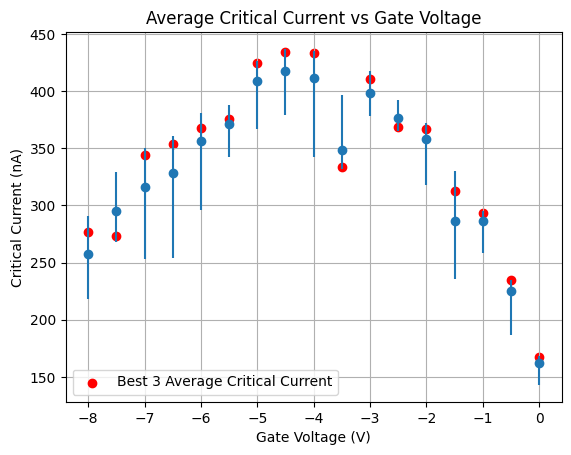

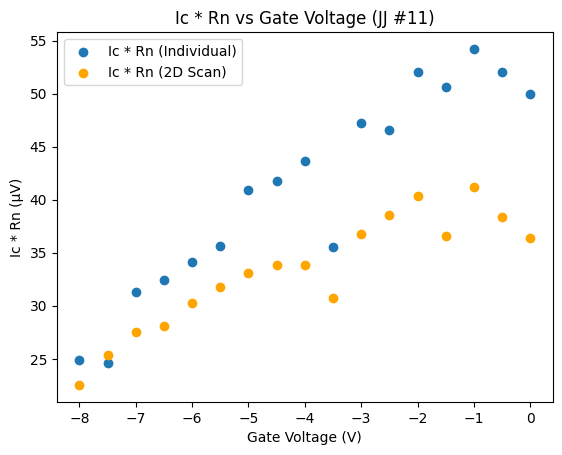

In [29]:
plot_V_vs_IcRn(11, r'/Users/ddoken/Downloads/LPS/LongIc/JJ11_Normal_Resistance', r"/Users/ddoken/Downloads/LPS/2DMapsColdRep/20250614-160700-130-95ba78-YokoVsGate_Repeat_JJ_307_01_JJ11_1nA_5reps/dataset.hdf5", np.arange(-8, 0.5, 0.5))

Processing gate voltage: -8.0 V
The normal resistance is,112.66121832328251for 20250618-125957-693-8b348c-RvsSource_JJ_307_01_JJ21_1nA_Vg=-8.0V
Processing gate voltage: -7.5 V
The normal resistance is,113.58283939285946for 20250618-130448-760-1eb325-RvsSource_JJ_307_01_JJ21_1nA_Vg=-7.5V
Processing gate voltage: -7.0 V
The normal resistance is,114.45232162214243for 20250618-130851-926-7e319f-RvsSource_JJ_307_01_JJ21_1nA_Vg=-7.0V
Processing gate voltage: -6.5 V
The normal resistance is,116.35463889477971for 20250618-131242-791-5574e6-RvsSource_JJ_307_01_JJ21_1nA_Vg=-6.5V
Processing gate voltage: -6.0 V
The normal resistance is,118.45141129910012for 20250618-131714-005-0660e4-RvsSource_JJ_307_01_JJ21_1nA_Vg=-6.0V
Processing gate voltage: -5.5 V
The normal resistance is,121.10243256438663for 20250618-132225-672-7232fe-RvsSource_JJ_307_01_JJ21_1nA_Vg=-5.5V
Processing gate voltage: -5.0 V
The normal resistance is,125.23819226633687for 20250618-132650-072-9048cb-RvsSource_JJ_307_01_JJ21_1nA_V

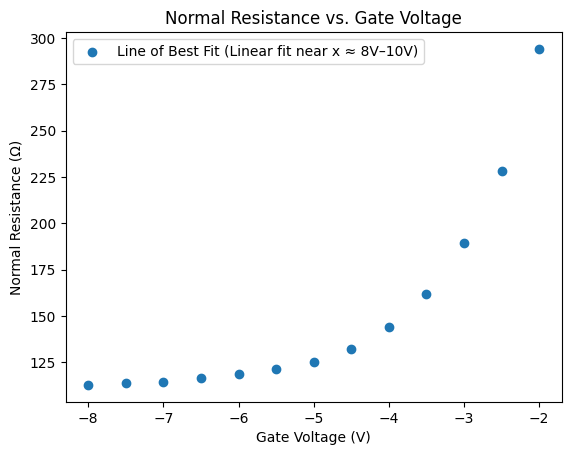

Resistance at critical current index is 1.7794413054:
Critical current: 154.0
Resistance at critical current index is 2.466506146:
Critical current: 151.0
Resistance at critical current index is 2.7313527085000002:
Critical current: 126.0
Resistance at critical current index is 3.0115290883:
Critical current: 130.0
Resistance at critical current index is 2.2506388575:
Critical current: 145.0
[np.float64(126.0)]
[np.float64(154.0)]
Resistance at critical current index is 3.4931085224000005:
Critical current: 146.0
Resistance at critical current index is 1.1842497827:
Critical current: 136.0
Resistance at critical current index is 1.5036584955:
Critical current: 167.0
Resistance at critical current index is 3.7160168631:
Critical current: 154.0
Resistance at critical current index is 2.9046807981:
Critical current: 168.0
[np.float64(126.0), np.float64(136.0)]
[np.float64(154.0), np.float64(168.0)]
Resistance at critical current index is 6.1121664885:
Critical current: 176.0
Resistance at

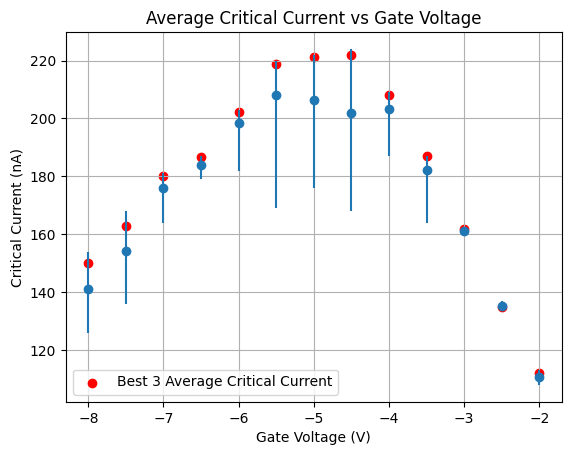

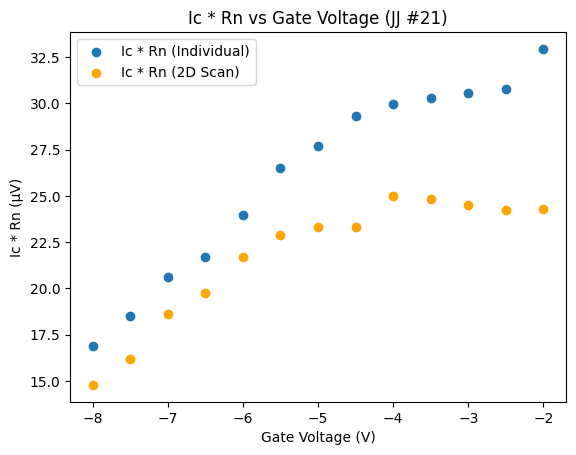

In [30]:
plot_V_vs_IcRn(21, r'/Users/ddoken/Downloads/LPS/LongIc/JJ21_Normal_Resistance', r"/Users/ddoken/Downloads/LPS/2DMapsColdRep/20250613-171758-794-0bd6b3-YokoVsGate_Repeat_JJ_307_01_JJ21_1nA_5reps/dataset.hdf5", np.arange(-8, -1.5, 0.5))

Processing gate voltage: -4.0 V
The normal resistance is,110.11823996510672for 20250624-112251-450-6d7ab5-RvsSource_JJ_307_01_JJ31_1nA_Vg=-4.0V
Processing gate voltage: -3.5 V
The normal resistance is,110.96881109495966for 20250624-113214-107-3aaf36-RvsSource_JJ_307_01_JJ31_1nA_Vg=-3.5V
Processing gate voltage: -3.0 V
The normal resistance is,112.24475677305752for 20250624-114000-828-64be0d-RvsSource_JJ_307_01_JJ31_1nA_Vg=-3.0V
Processing gate voltage: -2.5 V
The normal resistance is,115.2400147004802for 20250624-114513-645-13ee98-RvsSource_JJ_307_01_JJ31_1nA_Vg=-2.5V
Processing gate voltage: -2.0 V
The normal resistance is,117.68134822703288for 20250624-115043-271-12fc4c-RvsSource_JJ_307_01_JJ31_1nA_Vg=-2.0V
Processing gate voltage: -1.5 V
The normal resistance is,120.6122282192021for 20250624-115730-930-0f979e-RvsSource_JJ_307_01_JJ31_1nA_Vg=-1.5V
Processing gate voltage: -1.0 V
The normal resistance is,126.22164103147334for 20250624-120231-801-5e485a-RvsSource_JJ_307_01_JJ31_1nA_Vg=

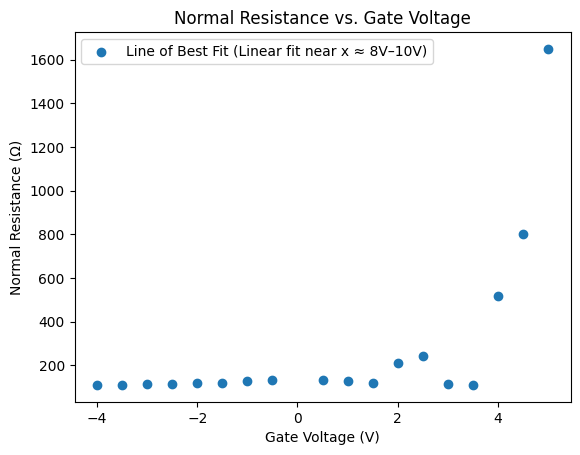

Resistance at critical current index is 0.9351464314000001:
Critical current: 139.0
Resistance at critical current index is 3.9779592953:
Critical current: 147.0
Resistance at critical current index is 6.0507971966:
Critical current: 140.0
Resistance at critical current index is 1.1106839537:
Critical current: 133.0
Resistance at critical current index is 1.6208541354:
Critical current: 148.0
[np.float64(133.0)]
[np.float64(148.0)]
Resistance at critical current index is 0.8497218573199999:
Critical current: 144.00000000000003
Resistance at critical current index is 4.129134652:
Critical current: 142.00000000000003
Resistance at critical current index is 1.7250573592:
Critical current: 146.0
Resistance at critical current index is 3.2006036577:
Critical current: 147.0
Resistance at critical current index is 4.5114583713:
Critical current: 128.0
[np.float64(133.0), np.float64(128.0)]
[np.float64(148.0), np.float64(147.0)]
Resistance at critical current index is 1.5601183634:
Critical cu

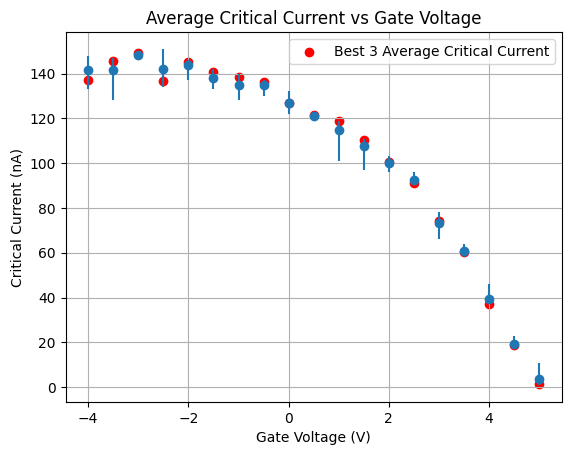

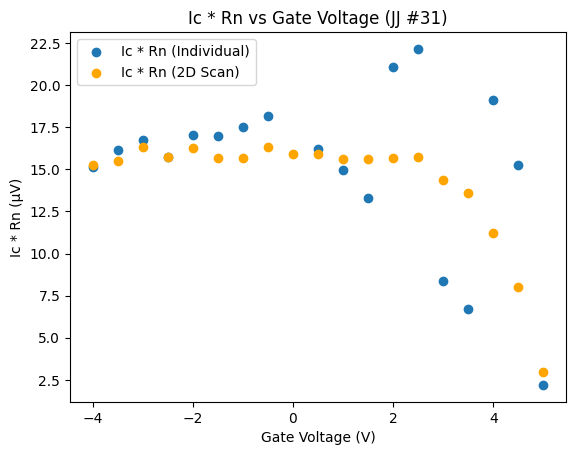

In [31]:
plot_V_vs_IcRn(31, r'/Users/ddoken/Downloads/LPS/LongIc/JJ31_Normal_Resistance', r"/Users/ddoken/Downloads/LPS/2DMapsColdRep/20250616-171611-816-68ed1c-YokoVsGate_Repeat_JJ_307_01_JJ31_1nA_5reps/dataset.hdf5", np.arange(-4, 5.5, 0.5))

Processing gate voltage: -8.0 V
The normal resistance is,67.08618408157828for 20250623-104732-351-6fca8b-RvsSource_JJ_307_01_JJ12_1nA_Vg=-8.0V
Processing gate voltage: -7.5 V
The normal resistance is,67.03918567608773for 20250623-105341-344-928aba-RvsSource_JJ_307_01_JJ12_1nA_Vg=-7.5V
Processing gate voltage: -7.0 V
The normal resistance is,66.92722848058816for 20250623-105839-049-f70e99-RvsSource_JJ_307_01_JJ12_1nA_Vg=-7.0V
Processing gate voltage: -6.5 V
The normal resistance is,67.41317376051616for 20250623-110709-440-bc29c5-RvsSource_JJ_307_01_JJ12_1nA_Vg=-6.5V
Processing gate voltage: -6.0 V
The normal resistance is,67.50880480453057for 20250623-111247-867-27eaa3-RvsSource_JJ_307_01_JJ12_1nA_Vg=-6.0V
Processing gate voltage: -5.5 V
The normal resistance is,68.26283842175228for 20250623-111708-122-5fce36-RvsSource_JJ_307_01_JJ12_1nA_Vg=-5.5V
Processing gate voltage: -5.0 V
The normal resistance is,68.66148620696082for 20250623-112724-347-3c5a6e-RvsSource_JJ_307_01_JJ12_1nA_Vg=-5.0V

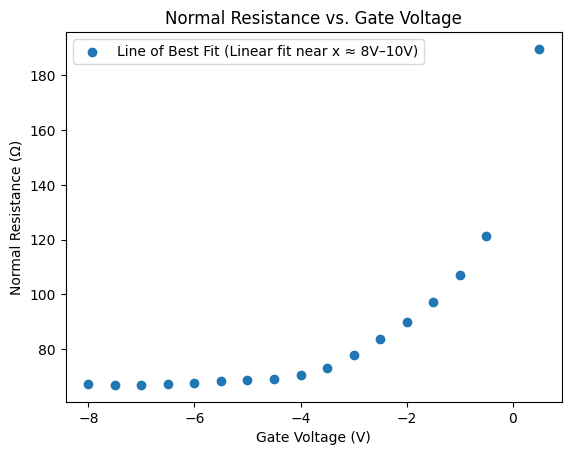

Resistance at critical current index is 1.8565769721999998:
Critical current: 402.0
Resistance at critical current index is 5.5897004358:
Critical current: 377.0
Resistance at critical current index is 2.2356164209:
Critical current: 380.0
Resistance at critical current index is 0.9808161394199999:
Critical current: 374.0
Resistance at critical current index is 2.238470671:
Critical current: 347.00000000000006
[np.float64(347.00000000000006)]
[np.float64(402.0)]
Resistance at critical current index is 3.7560943156:
Critical current: 382.0
Resistance at critical current index is 3.8356753862:
Critical current: 405.0
Resistance at critical current index is 2.6850884183:
Critical current: 378.0
Resistance at critical current index is 3.5153919953:
Critical current: 329.0
Resistance at critical current index is 2.1565475094999997:
Critical current: 485.0
[np.float64(347.00000000000006), np.float64(329.0)]
[np.float64(402.0), np.float64(485.0)]
Resistance at critical current index is 0.9824

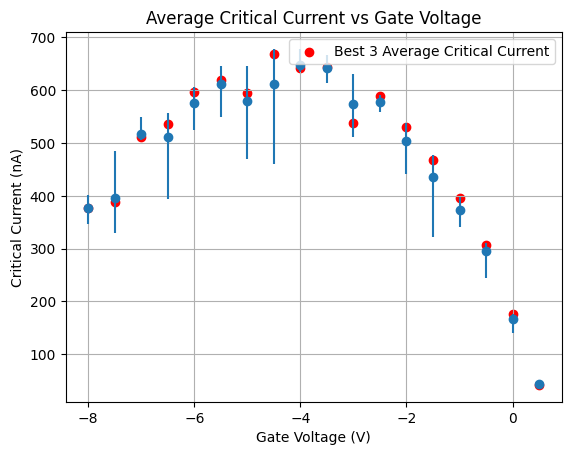

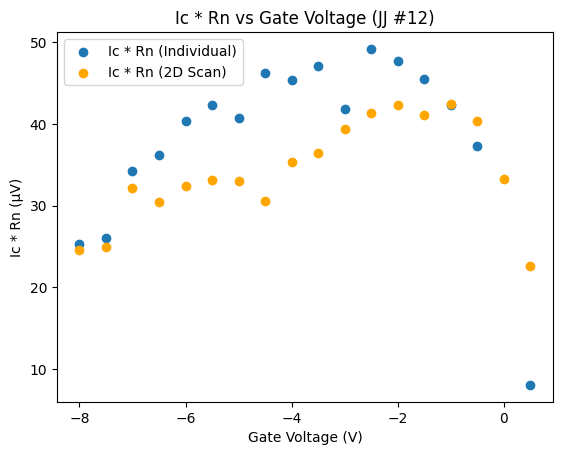

In [32]:
plot_V_vs_IcRn(12, r'/Users/ddoken/Downloads/LPS/LongIc/JJ12_Normal_Resistance', r"/Users/ddoken/Downloads/LPS/2DMapsColdRep/20250620-091859-908-6c02bd-YokoVsGate_Repeat_JJ_307_01_JJ12_1nA_5reps/dataset.hdf5", np.arange(-8, 1.0, 0.5))

Processing gate voltage: -4.0 V
The normal resistance is,68.96911708697881for 20250624-132912-211-b99c72-RvsSource_JJ_307_01_JJ33_1nA_Vg=-4.0V
Processing gate voltage: -3.5 V
The normal resistance is,69.69185684092422for 20250624-133309-812-1c3ee7-RvsSource_JJ_307_01_JJ33_1nA_Vg=-3.5V
Processing gate voltage: -3.0 V
The normal resistance is,70.1540030048606for 20250624-135847-438-76f6d4-RvsSource_JJ_307_01_JJ33_1nA_Vg=-3.0V
Processing gate voltage: -2.5 V
The normal resistance is,71.04957639174931for 20250624-140540-583-88027a-RvsSource_JJ_307_01_JJ33_1nA_Vg=-2.5V
Processing gate voltage: -2.0 V
The normal resistance is,72.1072381796281for 20250624-141204-249-78c7fb-RvsSource_JJ_307_01_JJ33_1nA_Vg=-2.0V
Processing gate voltage: -1.5 V
The normal resistance is,74.18023566501662for 20250624-142155-571-efb7f0-RvsSource_JJ_307_01_JJ33_1nA_Vg=-1.5V
Processing gate voltage: -1.0 V
The normal resistance is,76.7658666345636for 20250624-142636-614-7ef8a3-RvsSource_JJ_307_01_JJ33_1nA_Vg=-1.0V
Pr

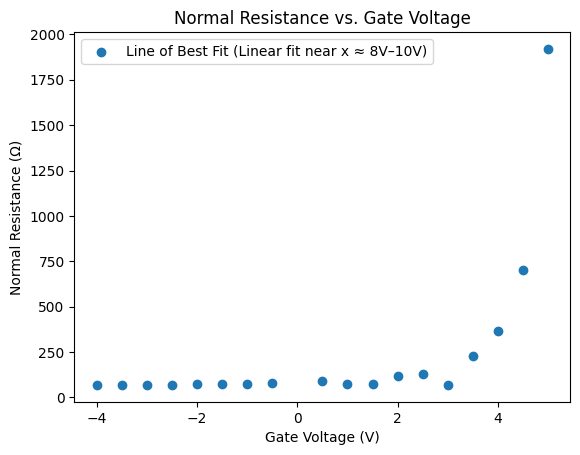

Resistance at critical current index is 3.7599880898:
Critical current: 178.0
Resistance at critical current index is 1.2927017679:
Critical current: 145.0
Resistance at critical current index is 5.1521277555000005:
Critical current: 194.0
Resistance at critical current index is 0.9093295005900001:
Critical current: 189.0
Resistance at critical current index is 3.0660055471999996:
Critical current: 181.0
[np.float64(145.0)]
[np.float64(194.0)]
Resistance at critical current index is 4.3380683223:
Critical current: 187.0
Resistance at critical current index is 2.3706466834:
Critical current: 193.0
Resistance at critical current index is 1.9226570203:
Critical current: 192.0
Resistance at critical current index is 1.4639709889:
Critical current: 179.0
Resistance at critical current index is 4.0516508193:
Critical current: 199.0
[np.float64(145.0), np.float64(179.0)]
[np.float64(194.0), np.float64(199.0)]
Resistance at critical current index is 3.5771583384:
Critical current: 189.0
Resist

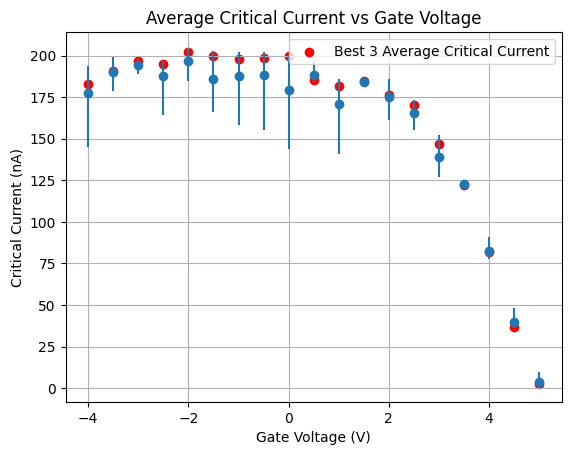

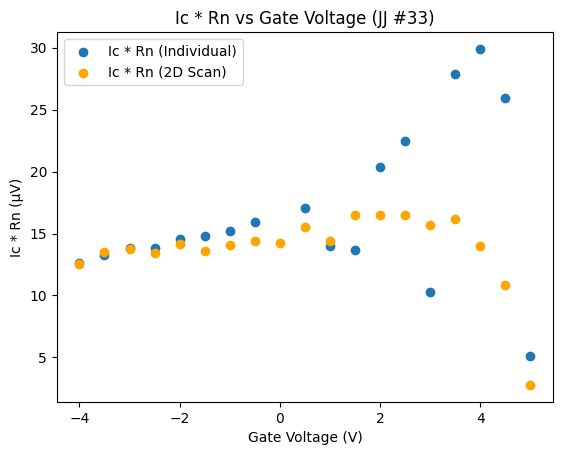

In [33]:
plot_V_vs_IcRn(33, r'/Users/ddoken/Downloads/LPS/LongIc/JJ33_Normal_Resistance', r"/Users/ddoken/Downloads/LPS/2DMapsColdRep/20250617-151627-025-5ec72f-YokoVsGate_Repeat_JJ_307_01_JJ33_1nA_5reps/dataset.hdf5", np.arange(-4, 5.5, 0.5))

Processing gate voltage: -4.0 V
The normal resistance is,75.74217568622876for 20250626-150414-083-439ae3-RvsSource_JJ_307_01_JJ13_1nA_Vg=-4.0V
Processing gate voltage: -3.5 V
The normal resistance is,84.18361454155432for 20250626-150734-988-ee8d5c-RvsSource_JJ_307_01_JJ13_1nA_Vg=-3.5V
Processing gate voltage: -3.0 V
The normal resistance is,97.02017130096029for 20250626-151052-468-687552-RvsSource_JJ_307_01_JJ13_1nA_Vg=-3.0V
Processing gate voltage: -2.5 V
The normal resistance is,112.56384835478568for 20250626-151413-885-82cddf-RvsSource_JJ_307_01_JJ13_1nA_Vg=-2.5V
Processing gate voltage: -2.0 V
The normal resistance is,132.6497279164719for 20250626-151829-815-1aba59-RvsSource_JJ_307_01_JJ13_1nA_Vg=-2.0V
Processing gate voltage: -1.5 V
The normal resistance is,162.82748897773803for 20250626-152134-431-544801-RvsSource_JJ_307_01_JJ13_1nA_Vg=-1.5V
Processing gate voltage: -1.0 V
The normal resistance is,218.50082511545185for 20250626-152528-522-85f2b2-RvsSource_JJ_307_01_JJ13_1nA_Vg=-1

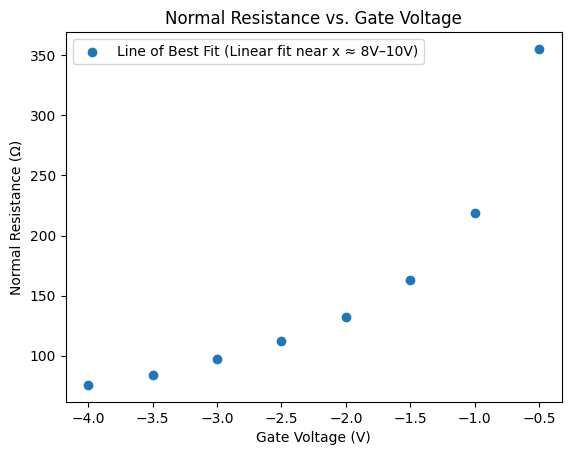

Resistance at critical current index is 3.521060421:
Critical current: 542.0
Resistance at critical current index is 2.8722237744:
Critical current: 529.0
Resistance at critical current index is 4.6668603204:
Critical current: 562.0
Resistance at critical current index is 3.4092994382999997:
Critical current: 397.0
Resistance at critical current index is 0.86872013583:
Critical current: 561.0
[np.float64(397.0)]
[np.float64(562.0)]
Resistance at critical current index is 1.6229770949:
Critical current: 503.0
Resistance at critical current index is 6.6393835140999995:
Critical current: 539.0
Resistance at critical current index is 0.86497358609:
Critical current: 461.0
Resistance at critical current index is 1.514754473:
Critical current: 531.0
Resistance at critical current index is 4.1840021936:
Critical current: 464.0
[np.float64(397.0), np.float64(461.0)]
[np.float64(562.0), np.float64(539.0)]
Resistance at critical current index is 5.1400701295:
Critical current: 479.00000000000006

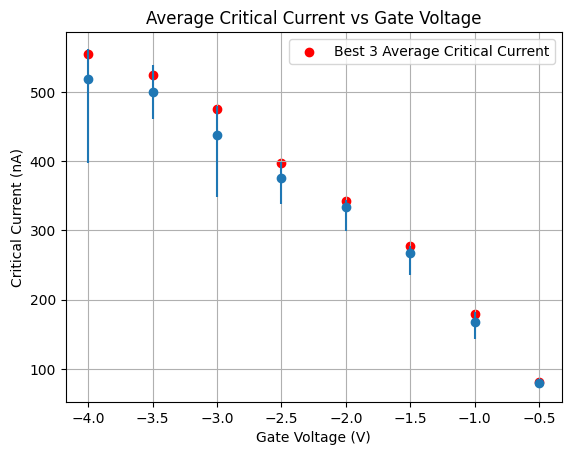

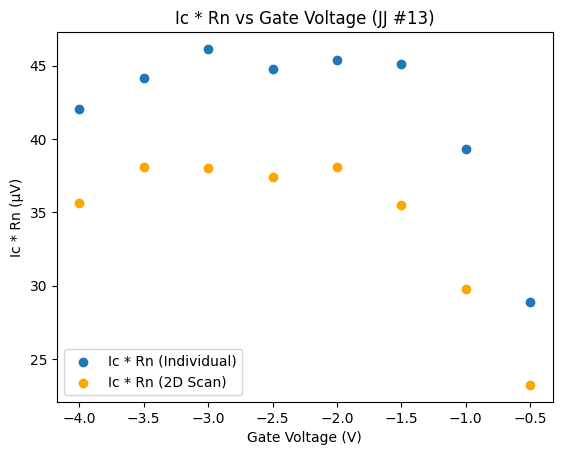

In [34]:
plot_V_vs_IcRn(13, r'/Users/ddoken/Downloads/LPS/LongIc/JJ13_Normal_Resistance', r"/Users/ddoken/Downloads/LPS/2DMapsColdRep/20250627-161704-717-5d99c6-YokoVsGate_Repeat_JJ_307_01_JJ13_1nA_5reps/dataset.hdf5", np.arange(-4, 0, 0.5))

Processing gate voltage: 14.0 V
The normal resistance is,320.53246127542815for 20250627-153909-921-50cacb-RvsSource_JJ_307_01_JJ41_1nA_Vg=14.0V
Processing gate voltage: 13.5 V
The normal resistance is,342.35482192949354for 20250627-153525-426-2cf1db-RvsSource_JJ_307_01_JJ41_1nA_Vg=13.5V
Processing gate voltage: 13.0 V
The normal resistance is,266.9853012499255for 20250627-152942-882-2f15e2-RvsSource_JJ_307_01_JJ41_1nA_Vg=13.0V
Processing gate voltage: 12.5 V
The normal resistance is,268.74146135973643for 20250627-152548-307-ecdbed-RvsSource_JJ_307_01_JJ41_1nA_Vg=12.5V
Processing gate voltage: 12.0 V
The normal resistance is,250.70701355895636for 20250627-152210-825-c00727-RvsSource_JJ_307_01_JJ41_1nA_Vg=12.0V
Processing gate voltage: 11.5 V
The normal resistance is,235.94137559676005for 20250627-151821-057-195549-RvsSource_JJ_307_01_JJ41_1nA_Vg=11.5V
Processing gate voltage: 11.0 V
The normal resistance is,226.68932771437179for 20250627-151430-225-d76e3e-RvsSource_JJ_307_01_JJ41_1nA_Vg

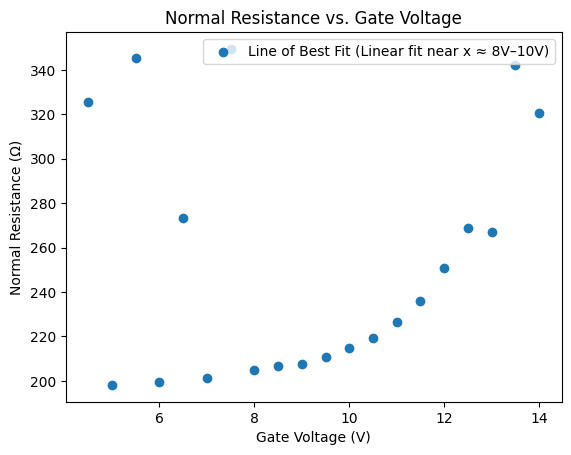

The gate values are: [15. 15. 15. ...  4.  4.  4.]
The fixed gate value is: 14.0
Number of points selected: 601


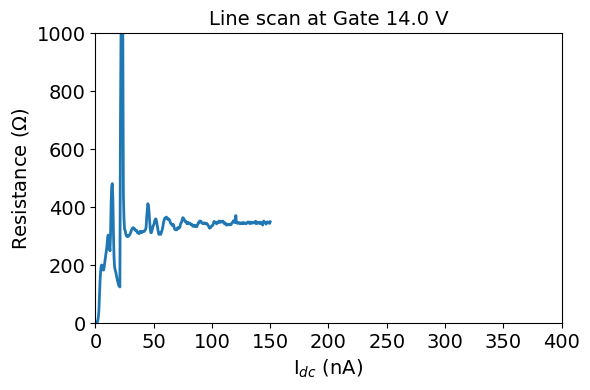

IndexError: index 57395 is out of bounds for axis 0 with size 601

In [35]:
plot_V_vs_IcRn(41, r'/Users/ddoken/Downloads/LPS/LongIc/JJ41_Normal_Resistance', r"/Users/ddoken/Downloads/LPS/2DMapsColdRep/20250611-163737-554-91f7e1-JJsweep_JJ_307_01_JJ41_1nA/dataset.hdf5", np.arange(14, 4, -0.5), 1e-6, False)